
# Feature Selection with Random Forest


https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

2. RAF Feature Importance w/ Normalization


3. RAF Feature Importance w/ Normalization w/ Lagged Observation


Training/Validation  Test


Custom functions to re-use

add_technical_indicator_features  
split_data_fwdchaining  
add_label  
get_label  
remove_label  


Variable importance for

1-day:  
  Closing
  
3-day:
  
5-day:  
  High
  
30-day:  
  High, Close, Low  


In [1]:
import talib
from talib.abstract import *
import numpy as np
import pandas as pd
import datetime as dt
import os, os.path

from sklearn.preprocessing import MinMaxScaler

pd.options.mode.chained_assignment = None # Suppress warning

In [2]:
# Load set of stocks from dataset

DATA_HOME = os.path.join("..","dataset","historical")

symbols = ["SCB","KBANK","AOT","BTS","AP","LH","CPF","KSL","PTT","RATCH"]
data = {}
for s in symbols:
    data[s] = pd.read_csv(os.path.join(DATA_HOME,"%s.csv" % s), index_col=0)

# Select single stock series for analysis    
ticker = "SCB"
df = data[ticker]
df.index = pd.to_datetime(df.index)

period_start='2014-01-01'
period_end='2014-12-31'

daily = df[period_start:period_end]
daily

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,142.0,131.5,141.5,131.5,14726700.0,98.861626
2014-01-03,135.5,131.0,132.0,132.5,15410800.0,99.613434
2014-01-06,140.0,130.5,132.0,140.0,12798300.0,105.251930
2014-01-07,144.0,139.0,141.0,144.0,9352800.0,108.259125
2014-01-08,144.5,140.0,143.5,140.5,10750100.0,105.627823
...,...,...,...,...,...,...
2014-12-24,186.0,184.0,185.0,184.5,1868200.0,143.104462
2014-12-25,184.0,181.5,182.5,183.0,2521600.0,141.940994
2014-12-26,184.5,181.0,182.0,184.5,2458300.0,143.104462


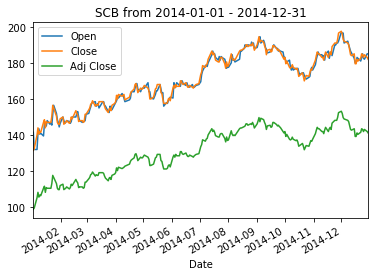

In [3]:
daily[['Open','Close','Adj Close']].plot(title="%s from %s - %s" % (ticker, period_start, period_end))

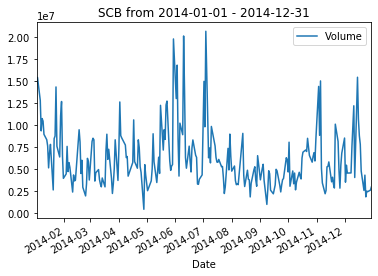

In [4]:
daily[['Volume']].plot(title="%s from %s - %s" % (ticker, period_start, period_end))

# Compute Technical Indicators

See TechnicalAnalysis/ folder for each indicator details.


## SMA

Simple n-day moving average. Average of the price over the calculation period.

## WMA

Weight average of last n-values. Use 14 days. So n=14 in [2]. n=10 in [9]

## EMA

Exponential Moving Average (EMA)
The weight of past prices decrease exponentially. [3] change value according to the input window being tested.

## RSI

Is an oscillator. Has value between 0-100. Evaluate magnitude of value change to assess overbought or oversold.
[2] calculate RSI using up/down and the end of period. Use n previouse day. [3] derive RSI from EMA and DM (direction movement indicator constructed from max function).
[9] use n=10,

## MOM

Momentum  
Indicate speed of the rise or fall in prices. [2] uses n+1; Security price rate of change. [11] sets to 10.


## Stochastic K%

the Stochastic Oscillator is used for three things; Identifying overbought and oversold levels, spotting divergences and also identifying bull and bear set ups or signals. https://www.tradingview.com/support/solutions/43000502332-stochastic-stoch/
See the calculation details.

## Stochastic D%

Momentum indicator over a particular period ... Indicate overbought or oversold.  
Is EMA(3) of Stochastic K%

In [5]:
def add_technical_indicator_features(daily):
    # Note the use of Close instead of Adj Close for TI calculation.
    inputs = {
        'open': daily["Open"],
        'high': daily["High"],
        'low': daily["Low"],
        'close': daily["Close"],
        'volume': daily["Volume"]
    }

    n = 5
    daily_sma = SMA(inputs, timeperiod=n)
    daily.loc[:,("SMA")] = daily_sma.tolist()    

    n = 5
    daily_wma = WMA(inputs, timeperiod=n)
    daily.loc[:,("WMA")] = daily_wma.tolist()  

    n = 5
    daily_ema = EMA(inputs, timeperiod=n)
    daily.loc[:,("EMA")] = daily_sma.tolist()

    n = 5
    rsi_5d = RSI(inputs, timeperiod=n)
    n = 10
    rsi_10d = RSI(inputs, timeperiod=n)
    n = 15
    rsi_15d = RSI(inputs, timeperiod=n)
    daily.loc[:,("RSI-5")] = rsi_5d.tolist()
    daily.loc[:,("RSI-10")] = rsi_10d.tolist()
    daily.loc[:,("RSI-15")] = rsi_15d.tolist()

    n = 10
    mom_t10 = MOM(inputs, timeperiod=n)
    daily.loc[:,("MOM-10")] = mom_t10.tolist()


    # STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    # See documentation in C code.
    slowk, slowd = STOCH(inputs, prices=['high', 'low', 'close']) # No need for period.!! Check out the C documentation.
    daily.loc[:,("Stoch-K")] = slowk.tolist()
    daily.loc[:,("Stoch-D")] = slowd.tolist()

    return daily

daily = add_technical_indicator_features(daily)

daily.head()

,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,EMA,RSI-5,RSI-10,RSI-15,MOM-10,Stoch-K,Stoch-D
Date,,,,,,,,,,,,,,,
2014-01-02,142.0,131.5,141.5,131.5,14726700.0,98.861626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,135.5,131.0,132.0,132.5,15410800.0,99.613434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,140.0,130.5,132.0,140.0,12798300.0,105.251930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,144.0,139.0,141.0,144.0,9352800.0,108.259125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,144.5,140.0,143.5,140.5,10750100.0,105.627823,137.7,139.666667,137.7,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
daily.dropna(inplace=True)
daily.describe().T

,count,mean,std,min,25%,50%,75%,max
High,230.0,1.737413e+02,1.393973e+01,147.000000,1.625000e+02,1.755000e+02,1.860000e+02,1.990000e+02
Low,230.0,1.709478e+02,1.389910e+01,143.500000,1.591250e+02,1.725000e+02,1.828750e+02,1.960000e+02
Open,230.0,1.723239e+02,1.403600e+01,144.500000,1.605000e+02,1.747500e+02,1.845000e+02,1.970000e+02
Close,230.0,1.724652e+02,1.392819e+01,146.000000,1.601250e+02,1.747500e+02,1.845000e+02,1.975000e+02
Volume,230.0,6.039598e+06,3.325518e+06,460600.000000,3.781450e+06,5.278250e+06,7.410675e+06,2.064500e+07
Adj Close,230.0,1.324702e+02,1.193571e+01,109.762726,1.224560e+02,1.353481e+02,1.430166e+02,1.531877e+02
SMA,230.0,1.721652e+02,1.393672e+01,146.800000,1.610000e+02,1.740500e+02,1.839750e+02,1.952000e+02
WMA,230.0,1.722683e+02,1.390677e+01,146.966667,1.611167e+02,1.742000e+02,1.840167e+02,1.957667e+02
EMA,230.0,1.721652e+02,1.393672e+01,146.800000,1.610000e+02,1.740500e+02,1.839750e+02,1.952000e+02
RSI-5,230.0,5.474001e+01,1.960654e+01,14.860899,4.030661e+01,5.538662e+01,6.972630e+01,9.462335e+01


Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'SMA', 'WMA',
       'EMA', 'RSI-5', 'RSI-10', 'RSI-15', 'MOM-10', 'Stoch-K', 'Stoch-D'],
      dtype='object')

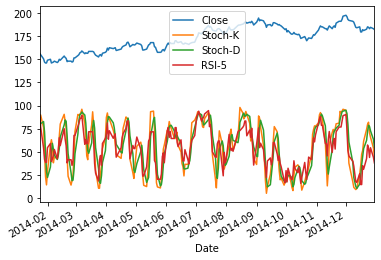

In [7]:
daily[['Close','Stoch-K','Stoch-D','RSI-5']].plot()


daily.columns

# Label Data: Add future value to column

In [8]:
def add_label(df_daily):
    """Add label to daily price dataframe. Do this before train/test split."""
    df_daily['1-day'] = df_daily['Close'].shift(-1) # Tomorrow's price
    df_daily['3-day'] = df_daily['Close'].shift(-3) # 
    df_daily['5-day'] = df_daily['Close'].shift(-3) # Price in five days
    df_daily['7-day'] = df_daily['Close'].shift(-3) # 
    df_daily['10-day'] = df_daily['Close'].shift(-3) # Price in ten days
    df_daily['15-day'] = df_daily['Close'].shift(-3) # 
    df_daily['20-day'] = df_daily['Close'].shift(-3) # 
    df_daily['30-day'] = df_daily['Close'].shift(-3) # Price in 30 days
    return df_daily

def get_label(df):
    """Get label columns from training set. Do this before remove label."""
    labels = ['1-day', '3-day', '5-day', '7-day', '10-day', '15-day', '20-day', '30-day']
    return df[labels]

def get_features(df):
    """Get feature columns from test set."""
    labels = ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'SMA', 'WMA',
       'EMA', 'RSI-5', 'RSI-10', 'RSI-15', 'MOM-10', 'Stoch-K', 'Stoch-D']
    return df[labels]
    

def remove_label(df):
    """Remove label from training dataset. So we don't leak information."""
    labels = ['1-day', '3-day', '5-day', '7-day', '10-day', '15-day', '20-day', '30-day']
    df.drop(labels, axis=1, inplace=True) # Drop columns defined above
    return df

daily = add_label(daily)
daily

,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,EMA,RSI-5,...,Stoch-K,Stoch-D,1-day,3-day,5-day,7-day,10-day,15-day,20-day,30-day
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-23,156.5,150.5,151.5,156.5,14332200.0,117.656586,149.6,151.100000,149.6,87.410327,...,82.222222,72.475634,155.0,147.0,147.0,147.0,147.0,147.0,147.0,147.0
2014-01-24,157.0,153.5,156.5,155.0,7609400.0,116.528893,151.2,152.900000,151.2,77.410551,...,90.000000,80.370370,150.5,146.0,146.0,146.0,146.0,146.0,146.0,146.0
2014-01-27,152.5,150.5,152.0,150.5,6392900.0,113.145844,151.9,152.666667,151.9,54.171080,...,76.388889,82.870370,147.0,146.0,146.0,146.0,146.0,146.0,146.0,146.0
2014-01-28,149.5,145.5,148.5,147.0,11064100.0,110.514511,151.9,151.033333,151.9,41.932252,...,48.611111,71.666667,146.0,149.0,149.0,149.0,149.0,149.0,149.0,149.0
2014-01-29,147.0,145.0,147.0,146.0,12681700.0,109.762726,151.0,149.066667,151.0,38.801406,...,23.611111,49.537037,146.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,186.0,184.0,185.0,184.5,1868200.0,143.104462,183.0,183.600000,183.0,54.064823,...,82.094017,78.727762,183.0,183.0,183.0,183.0,183.0,183.0,183.0,183.0
2014-12-25,184.0,181.5,182.5,183.0,2521600.0,141.940994,183.2,183.600000,183.2,44.071011,...,70.555556,77.470085,184.5,182.0,182.0,182.0,182.0,182.0,182.0,182.0
2014-12-26,184.5,181.0,182.0,184.5,2458300.0,143.104462,183.9,184.033333,183.9,54.568462,...,65.909091,72.852888,183.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Split Data 80/20



In [9]:
def split_data_fwdchaining(dataframe, training_pct=0.8):
    daily = dataframe
    dataset_total_days = len(daily)
    traintest_split_at = int(dataset_total_days * training_pct)
    split_date = daily[traintest_split_at:traintest_split_at+1].index.strftime("%Y-%m-%d").values[0]
    print('Data series total days:', dataset_total_days)
    print('Data series train/test split at:', traintest_split_at)
    print('Data series train/test split at:', split_date)

    train = daily[:traintest_split_at]
    test = daily[traintest_split_at:]

    train_from = train.head(1).index.strftime("%Y-%m-%d").values[0]
    train_to = train.tail(1).index.strftime("%Y-%m-%d").values[0]

    test_from = test.head(1).index.strftime("%Y-%m-%d").values[0]
    test_to = test.tail(1).index.strftime("%Y-%m-%d").values[0]

    print("Training set: %s - %s" % (train_from, train_to))
    print("Test set: %s - %s" % (test_from, test_to))
    return train, test

train, test = split_data_fwdchaining(daily)

Data series total days: 230
Data series train/test split at: 184
Data series train/test split at: 2014-10-24
Training set: 2014-01-23 - 2014-10-22
Test set: 2014-10-24 - 2014-12-30


In [10]:
# traintest_split_at = int(dataset_total_days*0.8)
# train = daily[:traintest_split_at]
# test = daily[traintest_split_at:]

# train.tail(1).index.strftime("%Y-%m-%d").values[0]

# Prepare Label / Remove Label from Training Set

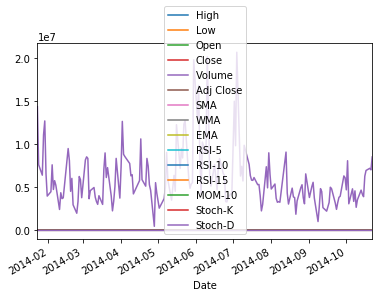

In [11]:
train_labels = get_label(train)


train = remove_label(train)
train.plot()

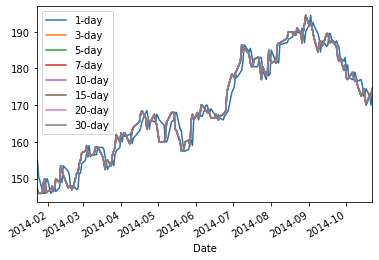

In [12]:
train_labels.plot()

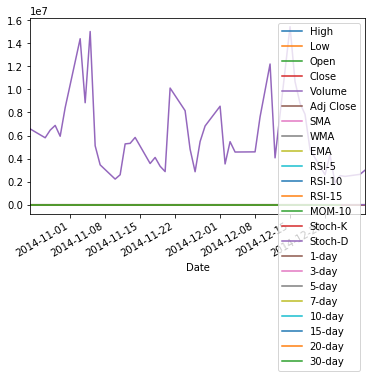

In [13]:
test.plot()

In [14]:
# Convert all to numpy array
# Labels are the values we want to predict
labels = np.array(train_labels['30-day'])

# Saving feature names for later use
feature_list = list(train.columns)

# Normalize
feature_scaler = MinMaxScaler()

features = np.array(train)
features = feature_scaler.fit_transform(features)

from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

# Train/Validation Set Split (IID?)

0.25 validation

In [15]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (138, 15)
Training Labels Shape: (138,)
Testing Features Shape: (46, 15)
Testing Labels Shape: (46,)


# Fit RF Model and Use MinMaxScaler

In [16]:
from sklearn.ensemble import RandomForestRegressor

train_features

array([[0.67368421, 0.68367347, 0.68      , ..., 0.69491525, 0.84637801,
        0.96388213],
       [0.28421053, 0.28571429, 0.28      , ..., 0.38983051, 0.79925315,
        0.88739099],
       [0.75789474, 0.7755102 , 0.74      , ..., 0.47457627, 0.28470244,
        0.11362223],
       ...,
       [0.50526316, 0.51020408, 0.51      , ..., 0.69491525, 0.66539519,
        0.66065504],
       [0.58947368, 0.59183673, 0.61      , ..., 0.11864407, 0.14150439,
        0.18761448],
       [0.43157895, 0.45918367, 0.44      , ..., 0.25423729, 0.44153265,
        0.35162545]])

In [17]:

rf = RandomForestRegressor(n_estimators = 10, criterion = 'mae', random_state = 1234)
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=1234, verbose=0, warm_start=False)

# Variable Importaince

Feature ranking:
1. feature 0 (0.288866)
2. feature 3 (0.147422)
3. feature 1 (0.119967)
4. feature 7 (0.104244)
5. feature 5 (0.088046)
6. feature 8 (0.080210)
7. feature 14 (0.031986)
8. feature 2 (0.023486)
9. feature 4 (0.023328)
10. feature 11 (0.020786)
11. feature 9 (0.019317)
12. feature 13 (0.017054)
13. feature 12 (0.013491)
14. feature 10 (0.012698)
15. feature 6 (0.009100)


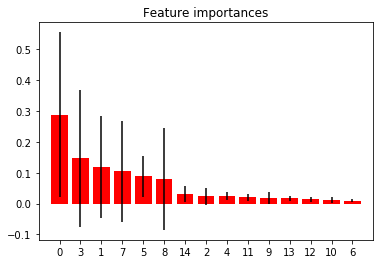

In [18]:
# Variable importance
#   https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = rf.feature_importances_
import matplotlib.pyplot as plt
X = train_features

std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

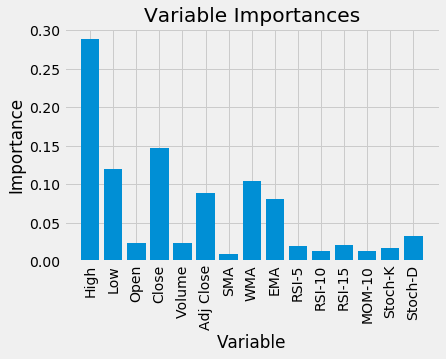

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# Prediction Performance

In [20]:
# Use the forest's predict method on the test data

# Also transform test features
test_features = feature_scaler.transform(test_features)

predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'Points')

Mean Absolute Error: 18.41 Points


In [21]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
print("MAPE:", round(np.mean(mape),4))
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

MAPE: 10.3725
Accuracy: 89.63 %.


Note on Scaling for RF. This seems to drop in comparison to w/o normalization

# Test Set (Holdout) - Evaluate Model



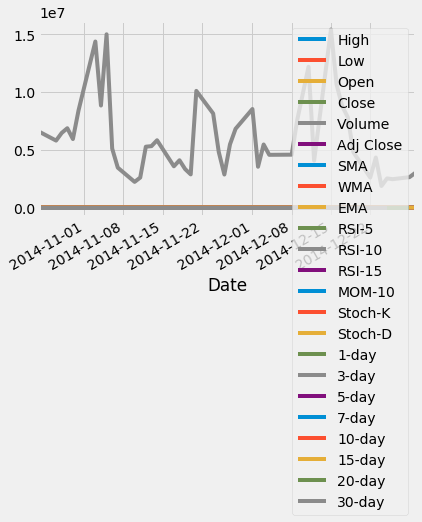

In [22]:
test.plot()

In [23]:
holdout_features = get_features(test)
holdout_labels = get_label(test)

holdout_features.tail()

,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,EMA,RSI-5,RSI-10,RSI-15,MOM-10,Stoch-K,Stoch-D
Date,,,,,,,,,,,,,,,
2014-12-24,186.0,184.0,185.0,184.5,1868200.0,143.104462,183.0,183.600000,183.0,54.064823,47.691231,48.299327,-5.5,82.094017,78.727762
2014-12-25,184.0,181.5,182.5,183.0,2521600.0,141.940994,183.2,183.600000,183.2,44.071011,43.591906,45.562563,-1.5,70.555556,77.470085
2014-12-26,184.5,181.0,182.0,184.5,2458300.0,143.104462,183.9,184.033333,183.9,54.568462,48.509559,48.678298,0.5,65.909091,72.852888
2014-12-29,185.5,183.0,185.0,183.0,2633100.0,141.940994,184.0,183.733333,184.0,44.198746,44.225579,45.865661,-2.0,54.242424,63.569024
2014-12-30,185.0,182.0,185.0,182.0,2993400.0,141.165359,183.4,183.066667,183.4,38.156332,41.510137,44.047744,2.5,44.242424,54.797980


In [24]:
holdout_labels.tail()

,1-day,3-day,5-day,7-day,10-day,15-day,20-day,30-day
Date,,,,,,,,
2014-12-24,183.0,183.0,183.0,183.0,183.0,183.0,183.0,183.0
2014-12-25,184.5,182.0,182.0,182.0,182.0,182.0,182.0,182.0
2014-12-26,183.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-29,182.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# NOTE: Testset will have label error. Have to drop
holdout_labels.dropna(inplace=True)

holdout_labels.tail()

,1-day,3-day,5-day,7-day,10-day,15-day,20-day,30-day
Date,,,,,,,,
2014-12-19,182.5,184.5,184.5,184.5,184.5,184.5,184.5,184.5
2014-12-22,185.0,183.0,183.0,183.0,183.0,183.0,183.0,183.0
2014-12-23,184.5,184.5,184.5,184.5,184.5,184.5,184.5,184.5
2014-12-24,183.0,183.0,183.0,183.0,183.0,183.0,183.0,183.0
2014-12-25,184.5,182.0,182.0,182.0,182.0,182.0,182.0,182.0


In [26]:

# testset (holdout)
holdout_features = feature_scaler.transform(holdout_features)


# Also transform test features
holdout_features = feature_scaler.transform(holdout_features)


holdout_features

array([[-3.08277008, -2.91732611, -2.8794    , -2.99883091, -0.02281959,
        -2.73448774, -3.20689058, -3.22250344, -3.20689058, -0.2014466 ,
        -0.3755721 , -0.56247916,  0.36110313, -0.0551649 , -0.15028867],
       [-3.0832133 , -2.91670137, -2.879     , -2.99904347, -0.02281959,
        -2.73473115, -3.20693867, -3.22251959, -3.20693867, -0.20187532,
        -0.37586494, -0.56277444,  0.36225223, -0.05349989, -0.14901559],
       [-3.08210526, -2.91670137, -2.8788    , -2.99819322, -0.02281959,
        -2.73375754, -3.20693867, -3.22219662, -3.20693867, -0.19971132,
        -0.37395702, -0.56082557,  0.36569951, -0.05100237, -0.14675025],
       [-3.08077562, -2.9150354 , -2.8774    , -2.99734297, -0.02281959,
        -2.73278393, -3.20655394, -3.22155069, -3.20655394, -0.19808958,
        -0.37231336, -0.559064  ,  0.36742315, -0.05039186, -0.14465715],
       [-3.08099723, -2.91566014, -2.8768    , -2.99755553, -0.02281959,
        -2.73302736, -3.20597684, -3.22111468, 

In [27]:
predictions = rf.predict(holdout_features)
predictions

array([150.85, 150.85, 150.85, 150.85, 150.85, 150.85, 150.85, 150.85,
       150.85, 150.85, 150.85, 150.85, 150.85, 150.85, 150.85, 150.85,
       150.85, 150.85, 150.85, 150.85, 150.85, 150.85, 150.85, 150.85,
       150.85, 150.85, 150.85, 150.85, 150.85, 150.85, 150.85, 150.85,
       150.85, 150.85, 150.85, 150.85, 150.85, 150.85, 150.85, 150.85,
       150.85, 150.85, 150.85, 150.85, 150.85, 150.85])

In [28]:
feature_scaler.inverse_transform(predictions)

ValueError: Expected 2D array, got 1D array instead:
array=[150.85 150.85 150.85 150.85 150.85 150.85 150.85 150.85 150.85 150.85
 150.85 150.85 150.85 150.85 150.85 150.85 150.85 150.85 150.85 150.85
 150.85 150.85 150.85 150.85 150.85 150.85 150.85 150.85 150.85 150.85
 150.85 150.85 150.85 150.85 150.85 150.85 150.85 150.85 150.85 150.85
 150.85 150.85 150.85 150.85 150.85 150.85].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
testset_labels['1-day']